# Derive models of spacecraft with star tracker

Do all imports.

In [53]:
!pip install control

   ---------------------------------------- 0.0/549.6 kB ? eta -:--:--
   --------------------------------------- 549.6/549.6 kB 11.5 MB/s eta 0:00:00


In [54]:
import sympy as sym
import numpy as np
from IPython.display import display, Markdown
import ae353_spacecraft_design as design
import control

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Create spacecraft

Create a visualizer to help with placement of reaction wheels.

In [31]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


Specify the location of four reaction wheels in terms of their right ascension $\alpha$ and declination $\delta$. You cannot change the number of wheels, but it is likely that you **must** change the location of wheels in order for the system to be controllable.

In [32]:
wheels = [
    {'alpha': 1 * np.pi / 2, 'delta': 0.},
    {'alpha': np.pi, 'delta': 0.},
    {'alpha': 3 * np.pi / 2, 'delta': 0.},
    {'alpha': 0, 'delta': -1 * np.pi / 2.},
]

Show wheels in the visualizer. You will be warned if any wheel obscures the star tracker (i.e., the "scope") or if any two wheels are too close together.

In [33]:
design.show_wheels(vis, wheels)

Create a model of the spacecraft in URDF format. This will **overwrite** the file `spacecraft.urdf` in the `urdf` directory. Also, compute the mass $m$ and inertia matrix $J$ of the spacecraft (including all the wheels). These parameters will be used later when deriving equations of motion.

In [34]:
m, J = design.create_spacecraft(wheels)

display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'
    +  r'$$'
))

$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}26.08 & 0.0 & 0.0\\0.0 & 23.72 & 0.0\\0.0 & 0.0 & 26.08\end{matrix}\right]$$

## Create stars

Specify the location of at most ten stars in terms of their right ascension $\alpha$ and declination $\delta$. It is likely that you **must** change the number and/or location of stars in order for the system to be observable.

In [35]:
stars = [
    {'alpha':  0, 'delta':  .1},
    {'alpha':  .1, 'delta':  -.1},
    {'alpha':  0, 'delta':  -.1},
    # <-- To add a star, append a copy of this dict to the list. To change
                                      #     the location of a star, change the value of alpha and delta
]

Show where the stars will appear in the scope. The plot on the left shows $\alpha$ and $\delta$ gridelines. The plot on the right shows $y_\text{star}$ and $z_\text{star}$ gridlines.

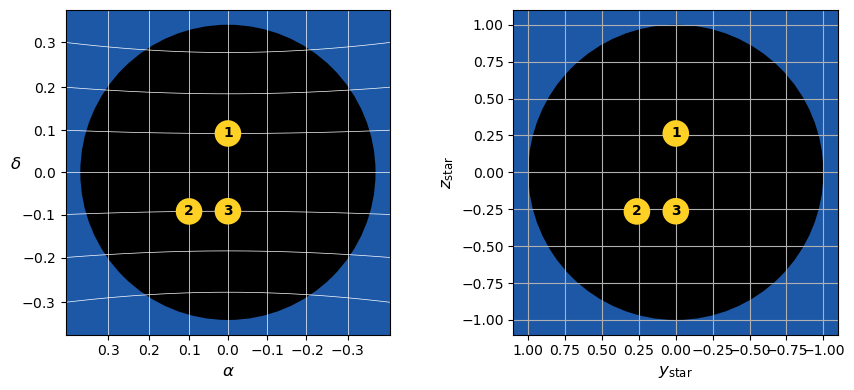

In [36]:
design.show_stars(stars)

Create a file with the location of stars. This will **overwrite** the file `stars.json` in the `urdf` directory.

In [37]:
design.create_stars(stars)

## Create dynamic model

Derive the equations of motion.

In [38]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right).$$

Here is the function $f$:

In [71]:
from scipy.signal import place_poles
from scipy import linalg
f
anum = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), f.jacobian((psi,theta,phi,w_x,w_y,w_z)))
A = anum(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)
A
bnum = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), f.jacobian((tau_1,tau_2,tau_3,tau_4)))
B = bnum(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)
B
print(B.shape)
W = B
for i in range(1,A.shape[0]):
    col = np.linalg.matrix_power(A,i) @ B
    W = np.block([W,col])
np.linalg.matrix_rank(W)
a = np.poly(A)[1:]
Q = np.eye(6)*100
R = np.eye(4)
P = linalg.solve_continuous_are(A,B,Q,R)
K = linalg.inv(R) @ B.T @ P
#latex(f)\
K

(6, 4)


array([[ -0.        ,  -7.07106781,  -0.        ,   0.        ,
        -14.75593147,  -0.        ],
       [  0.        ,  -0.        ,  10.        ,  24.93290998,
         -0.        ,   0.        ],
       [  0.        ,   7.07106781,   0.        ,  -0.        ,
         14.75593147,   0.        ],
       [ 10.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,  24.93290998]])

## Create sensor model

Create symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star.

In [ ]:
alpha, delta = sym.symbols('alpha, delta')

Derive the sensor model for one star.

In [ ]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])
print(sym.latex(g))

g = sym.simplify(p_star_in_image, full = True)
#print(g)

G = g.subs({alpha: 0,delta: .1})

for i in range(1, len(stars)):
    #print(stars[i]['alpha'],stars[i]['delta'])
    G = np.vstack((G,g.subs({alpha:stars[i]['alpha'], delta: stars[i]['delta']})))

# Sensor model for each star
G = sym.simplify(sym.Matrix(G))
G.shape

#G

The sensor model has the following form:

$$\begin{bmatrix} y_\text{star} \\ z_\text{star} \end{bmatrix} = g(\psi, \theta, \phi, \alpha, \delta).$$

Here is the function $g$:

In [72]:
from scipy.signal import place_poles
g
cnum = sym.lambdify((psi,theta,phi), G.jacobian(([psi,theta,phi,w_x,w_y,w_z])))
C = cnum(0,0,0).T
print(A.T.shape, C.T.shape,Q.shape,R.shape)
Q0 = np.diag((1,1,1,1,1,1))
R0 = np.diag((1,1,1,1,1,1))*100

P = linalg.solve_continuous_are(A.T,C.T,linalg.inv(R0),linalg.inv(Q0))
L = (Q0 @ C @ P).T


print(G.subs({(phi,0),(psi,0),(theta,0)}))
L

(6, 6) (6, 6) (6, 6) (4, 4)
Matrix([[0], [0.263378514224308], [0.263378514224308], [-0.264700916252661], [0], [-0.263378514224308]])


array([[-0.19792576, -0.02163259,  0.4897433 ,  0.        ,  0.        ,
         0.        ],
       [ 0.13673611,  0.30632324, -0.0075213 ,  0.        ,  0.        ,
         0.        ],
       [-0.18380976, -0.07489003, -0.48554779,  0.        ,  0.        ,
         0.        ],
       [-0.06941481,  0.00500694, -0.07180887,  0.        ,  0.        ,
         0.        ],
       [ 0.01180116,  0.09919962, -0.00449092,  0.        ,  0.        ,
         0.        ],
       [-0.07100927,  0.01159164,  0.06945011,  0.        ,  0.        ,
         0.        ]])

Again, this sensor model is for **one star only**. You will have to use a copy of this same model for each star you defined in the "Create Stars" section of this notebook.